# Financial Sentiment Analysis
## Part 1: Dataset Selection & Research Analysis

**Dataset:** Financial PhraseBank (Malo et al., 2014)

**Objective:** Analyze the dataset, perform EDA, and review related work for financial sentiment classification.

---

## Setup and Imports

In [1]:
# Standard library imports
import sys
import warnings
from pathlib import Path

# Add project root to path
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Project modules
from config.paths import FIGURES_DIR, REPORTS_DIR, PROCESSED_DATA_DIR
from config.params import RANDOM_SEED, LABEL_NAMES, SENTIMENT_COLORS
from src.data.loader import load_financial_phrasebank, DataLoader
from src.data.preprocessor import FinancialTextPreprocessor
from src.data.analyzer import DatasetAnalyzer, export_to_report
from src.visualization.plots import (
    set_plot_style,
    plot_label_distribution,
    plot_text_length_distribution,
    plot_word_frequency,
    generate_wordcloud,
    generate_all_wordclouds,
    plot_sentiment_scatter,
)
from src.utils.helpers import setup_logging, set_random_seed, timer

# Setup
set_random_seed(RANDOM_SEED)
set_plot_style()
logger = setup_logging()

print(f"Project root: {PROJECT_ROOT}")
print(f"Python version: {sys.version}")
print("Setup complete!")

2026-01-24 09:56:10 - root - INFO - Logging initialized. Log file: C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\outputs\logs\main.log


Project root: C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis
Python version: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
Setup complete!


---
# Section 1: Dataset Overview

## 1.1 Dataset Description

The **Financial PhraseBank** dataset contains sentences from financial news, annotated for sentiment polarity. It was created by Malo et al. (2014) and is widely used for financial sentiment analysis research.

### Key Characteristics:
- **Domain:** Financial news and reports
- **Language:** English
- **Task:** Sentiment classification (3 classes)
- **Annotation:** Multiple annotators with agreement thresholds

### Why Financial PhraseBank?

1. **Domain Specificity:** Specifically designed for financial text analysis
2. **Quality Annotations:** Multiple annotators with varying agreement levels
3. **Benchmark Status:** Widely used in financial NLP research
4. **Manageable Size:** Suitable for fine-tuning experiments
5. **Real-world Relevance:** Sentences from actual financial news

## 1.2 Loading the Dataset

In [2]:
# Load dataset with 75% agreement threshold
# This provides a balance between data quality and quantity

with timer("Dataset loading"):
    df = load_financial_phrasebank(
        agreement_level="sentences_75agree",
        source="huggingface",
        save_local=True
    )

print(f"\nDataset loaded: {len(df):,} samples")
print(f"Columns: {list(df.columns)}")

2026-01-24 09:56:10 - src.utils.helpers - INFO - Dataset loading started...
2026-01-24 09:56:10 - src.data.loader - INFO - DataLoader initialized with agreement_level=sentences_75agree, version=1.0.0
2026-01-24 09:56:10 - src.data.loader - INFO - Loading dataset from HuggingFace: takala/financial_phrasebank
2026-01-24 09:56:10 - src.data.loader - INFO - Configuration: sentences_75agree
2026-01-24 09:56:11 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/datasets/takala/financial_phrasebank/resolve/main/data/FinancialPhraseBank-v1.0.zip "HTTP/1.1 302 Found"
2026-01-24 09:56:11 - src.data.loader - INFO - Dataset loaded successfully: 3453 samples
2026-01-24 09:56:11 - src.data.loader - INFO - Label distribution:
label_name
neutral     2146
positive     887
negative     420
Name: count, dtype: int64
2026-01-24 09:56:11 - src.data.loader - INFO - Dataset saved to C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\data\raw\financial_phrasebank_sentences_75agree.csv
2026-0


Dataset loaded: 3,453 samples
Columns: ['sentence', 'label', 'split', 'label_name', 'data_version', 'agreement_level']


In [3]:
# Display sample data
print("\n=== Sample Data ===")
df.head(10)


=== Sample Data ===


,sentence,label,split,label_name,data_version,agreement_level
0,"According to Gran , the company has no plans t...",1,train,neutral,1.0.0,sentences_75agree
1,With the new production plant the company woul...,2,train,positive,1.0.0,sentences_75agree
2,"For the last quarter of 2010 , Componenta 's n...",2,train,positive,1.0.0,sentences_75agree
3,"In the third quarter of 2010 , net sales incre...",2,train,positive,1.0.0,sentences_75agree
4,Operating profit rose to EUR 13.1 mn from EUR ...,2,train,positive,1.0.0,sentences_75agree
5,"Operating profit totalled EUR 21.1 mn , up fro...",2,train,positive,1.0.0,sentences_75agree
6,TeliaSonera TLSN said the offer is in line wit...,2,train,positive,1.0.0,sentences_75agree
7,"STORA ENSO , NORSKE SKOG , M-REAL , UPM-KYMMEN...",2,train,positive,1.0.0,sentences_75agree
8,"A purchase agreement for 7,200 tons of gasolin...",2,train,positive,1.0.0,sentences_75agree
9,Finnish Talentum reports its operating profit ...,2,train,positive,1.0.0,sentences_75agree


In [4]:
# Dataset info
print("\n=== Dataset Info ===")
df.info()


=== Dataset Info ===
<class 'pandas.DataFrame'>
RangeIndex: 3453 entries, 0 to 3452
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   sentence         3453 non-null   str  
 1   label            3453 non-null   int64
 2   split            3453 non-null   str  
 3   label_name       3453 non-null   str  
 4   data_version     3453 non-null   str  
 5   agreement_level  3453 non-null   str  
dtypes: int64(1), str(5)
memory usage: 700.9 KB


## 1.3 Comparing Agreement Levels

In [5]:
# Load all agreement levels for comparison
agreement_levels = [
    "sentences_50agree",
    "sentences_66agree", 
    "sentences_75agree",
    "sentences_allagree"
]

comparison_data = []

for level in agreement_levels:
    try:
        temp_df = load_financial_phrasebank(agreement_level=level, save_local=False)
        counts = temp_df['label_name'].value_counts()
        comparison_data.append({
            'Agreement Level': level.replace('sentences_', '').replace('agree', '% agree'),
            'Total Samples': len(temp_df),
            'Positive': counts.get('positive', 0),
            'Neutral': counts.get('neutral', 0),
            'Negative': counts.get('negative', 0),
        })
    except Exception as e:
        print(f"Error loading {level}: {e}")

comparison_df = pd.DataFrame(comparison_data)
print("\n=== Agreement Level Comparison ===")
comparison_df

2026-01-24 09:56:12 - src.data.loader - INFO - DataLoader initialized with agreement_level=sentences_50agree, version=1.0.0
2026-01-24 09:56:12 - src.data.loader - INFO - Loading dataset from HuggingFace: takala/financial_phrasebank
2026-01-24 09:56:12 - src.data.loader - INFO - Configuration: sentences_50agree
2026-01-24 09:56:12 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/datasets/takala/financial_phrasebank/resolve/main/data/FinancialPhraseBank-v1.0.zip "HTTP/1.1 302 Found"
2026-01-24 09:56:12 - src.data.loader - INFO - Dataset loaded successfully: 4846 samples
2026-01-24 09:56:12 - src.data.loader - INFO - Label distribution:
label_name
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64
2026-01-24 09:56:12 - src.data.loader - INFO - DataLoader initialized with agreement_level=sentences_66agree, version=1.0.0
2026-01-24 09:56:12 - src.data.loader - INFO - Loading dataset from HuggingFace: takala/financial_phrasebank
2026-01-24 09:56:12 - src.


=== Agreement Level Comparison ===


,Agreement Level,Total Samples,Positive,Neutral,Negative
0,50% agree,4846,1363,2879,604
1,66% agree,4217,1168,2535,514
2,75% agree,3453,887,2146,420
3,all% agree,2264,570,1391,303


## 1.4 Dataset Summary Table

In [6]:
# Create summary table for report
summary_table = pd.DataFrame({
    'Property': [
        'Dataset Name',
        'Source',
        'Domain',
        'Language',
        'Task Type',
        'Number of Classes',
        'Total Samples (75% agree)',
        'Agreement Level Used',
    ],
    'Value': [
        'Financial PhraseBank',
        'Malo et al. (2014) / HuggingFace',
        'Financial News',
        'English',
        'Multi-class Sentiment Classification',
        '3 (Positive, Neutral, Negative)',
        f'{len(df):,}',
        '75% annotator agreement',
    ]
})

print("\n=== Dataset Summary ===")
summary_table


=== Dataset Summary ===


,Property,Value
0,Dataset Name,Financial PhraseBank
1,Source,Malo et al. (2014) / HuggingFace
2,Domain,Financial News
3,Language,English
4,Task Type,Multi-class Sentiment Classification
5,Number of Classes,"3 (Positive, Neutral, Negative)"
6,Total Samples (75% agree),"3,453"
7,Agreement Level Used,75% annotator agreement


---
# Section 2: Data Quality Analysis

## 2.1 Initialize Preprocessor and Analyzer

In [7]:
# Initialize preprocessor
preprocessor = FinancialTextPreprocessor()

# Preprocess data
with timer("Data preprocessing"):
    df_processed = preprocessor.preprocess_dataframe(
        df,
        text_column='sentence',
        remove_duplicates=False,  # Keep duplicates for analysis
        add_text_features=True
    )

print(f"\nProcessed dataset: {len(df_processed):,} samples")
print(f"New columns: {[c for c in df_processed.columns if c not in df.columns]}")

2026-01-24 09:56:13 - src.data.preprocessor - INFO - Preprocessor initialized with 214 stopwords
2026-01-24 09:56:13 - src.utils.helpers - INFO - Data preprocessing started...
2026-01-24 09:56:13 - src.data.preprocessor - INFO - Starting preprocessing pipeline on 3453 rows
2026-01-24 09:56:13 - src.data.preprocessor - INFO - Missing values check:
            column  missing_count  missing_percent  dtype
0         sentence              0              0.0    str
1            label              0              0.0  int64
2            split              0              0.0    str
3       label_name              0              0.0    str
4     data_version              0              0.0    str
5  agreement_level              0              0.0    str
2026-01-24 09:56:13 - src.data.preprocessor - INFO - Cleaning text...
2026-01-24 09:56:13 - src.data.preprocessor - INFO - Adding text features...
2026-01-24 09:56:13 - src.data.preprocessor - INFO - Preprocessing complete. Final dataset: 3453 r


Processed dataset: 3,453 samples
New columns: ['sentence_clean', 'char_count', 'word_count', 'char_count_clean', 'word_count_clean']


In [8]:
# Initialize analyzer
analyzer = DatasetAnalyzer(df_processed, text_column='sentence', label_column='label_name')

2026-01-24 09:56:14 - src.data.analyzer - INFO - DatasetAnalyzer initialized with 3453 samples


## 2.2 Missing Values Check

In [9]:
# Check missing values
missing_stats = preprocessor.check_missing_values(df_processed)

print("\n=== Missing Values Analysis ===")
missing_stats[missing_stats['missing_count'] > 0] if missing_stats['missing_count'].sum() > 0 else print("No missing values found!")
missing_stats

2026-01-24 09:56:14 - src.data.preprocessor - INFO - Missing values check:
              column  missing_count  missing_percent  dtype
0           sentence              0              0.0    str
1              label              0              0.0  int64
2              split              0              0.0    str
3         label_name              0              0.0    str
4       data_version              0              0.0    str
5    agreement_level              0              0.0    str
6     sentence_clean              0              0.0    str
7         char_count              0              0.0  int64
8         word_count              0              0.0  int64
9   char_count_clean              0              0.0  int64
10  word_count_clean              0              0.0  int64



=== Missing Values Analysis ===
No missing values found!


,column,missing_count,missing_percent,dtype
0,sentence,0,0.0,str
1,label,0,0.0,int64
2,split,0,0.0,str
3,label_name,0,0.0,str
4,data_version,0,0.0,str
5,agreement_level,0,0.0,str
6,sentence_clean,0,0.0,str
7,char_count,0,0.0,int64
8,word_count,0,0.0,int64
9,char_count_clean,0,0.0,int64


## 2.3 Duplicate Analysis

In [10]:
# Check duplicates
duplicate_texts = df_processed['sentence'].duplicated().sum()
duplicate_rows = df_processed.duplicated().sum()

print("\n=== Duplicate Analysis ===")
print(f"Duplicate texts: {duplicate_texts} ({duplicate_texts/len(df_processed)*100:.2f}%)")
print(f"Duplicate rows (all columns): {duplicate_rows} ({duplicate_rows/len(df_processed)*100:.2f}%)")

# Show examples of duplicates
if duplicate_texts > 0:
    print("\nExample duplicate sentences:")
    duplicated_sentences = df_processed[df_processed['sentence'].duplicated(keep=False)]
    duplicated_sentences.groupby('sentence').size().sort_values(ascending=False).head(5)


=== Duplicate Analysis ===
Duplicate texts: 5 (0.14%)
Duplicate rows (all columns): 5 (0.14%)

Example duplicate sentences:


## 2.4 Text Statistics

In [11]:
# Get text statistics
text_stats = analyzer.get_text_stats()

# Create text statistics table
text_stats_table = pd.DataFrame({
    'Metric': ['Minimum', 'Maximum', 'Mean', 'Median', 'Std Dev'],
    'Word Count': [
        text_stats['word_count']['min'],
        text_stats['word_count']['max'],
        f"{text_stats['word_count']['mean']:.1f}",
        f"{text_stats['word_count']['median']:.1f}",
        f"{text_stats['word_count']['std']:.1f}",
    ],
    'Character Length': [
        text_stats['character_length']['min'],
        text_stats['character_length']['max'],
        f"{text_stats['character_length']['mean']:.1f}",
        f"{text_stats['character_length']['median']:.1f}",
        f"{text_stats['character_length']['std']:.1f}",
    ],
})

print("\n=== Text Length Statistics ===")
text_stats_table

2026-01-24 09:56:14 - src.data.analyzer - INFO - Text stats: avg 22.8 words, avg 124.9 chars



=== Text Length Statistics ===


,Metric,Word Count,Character Length
0,Minimum,2,9
1,Maximum,81,315
2,Mean,22.8,124.9
3,Median,21.0,116.0
4,Std Dev,10.1,56.4


In [12]:
# Text stats by class
print("\n=== Text Statistics by Sentiment Class ===")
stats_by_class = pd.DataFrame(text_stats['text_stats_by_class']).T
stats_by_class = stats_by_class.round(2)
stats_by_class


=== Text Statistics by Sentiment Class ===


,count,avg_word_count,avg_char_count,std_word_count
neutral,2146.0,21.55,120.94,9.76
positive,887.0,24.88,133.64,10.31
negative,420.0,24.47,126.39,10.13


## 2.5 Data Quality Summary

In [13]:
# Get comprehensive data quality report
quality_report = analyzer.check_data_quality()

quality_table = pd.DataFrame({
    'Quality Metric': [
        'Total Samples',
        'Duplicate Texts',
        'Missing Values',
        'Empty Texts',
        'Short Texts (<3 words)',
        'Very Long Texts (>99th percentile)',
        'Data Quality Score',
    ],
    'Value': [
        f"{len(df_processed):,}",
        f"{quality_report['duplicate_texts']} ({quality_report['duplicate_texts']/len(df_processed)*100:.1f}%)",
        str(quality_report['total_missing']),
        str(quality_report['empty_texts']),
        str(quality_report['short_texts_under_3_words']),
        str(quality_report['long_texts_above_99th_percentile']),
        f"{quality_report['data_quality_score']:.1f}%",
    ],
    'Status': [
        '✓',
        '⚠' if quality_report['duplicate_texts'] > 0 else '✓',
        '✓' if quality_report['total_missing'] == 0 else '✗',
        '✓' if quality_report['empty_texts'] == 0 else '✗',
        '✓',
        '✓',
        '✓' if quality_report['data_quality_score'] >= 95 else '⚠',
    ]
})

print("\n=== Data Quality Summary ===")
quality_table

2026-01-24 09:56:14 - src.data.analyzer - INFO - Data quality check: 5 duplicates, 0 missing values



=== Data Quality Summary ===


,Quality Metric,Value,Status
0,Total Samples,"3,453",✓
1,Duplicate Texts,5 (0.1%),⚠
2,Missing Values,0,✓
3,Empty Texts,0,✓
4,Short Texts (<3 words),1,✓
5,Very Long Texts (>99th percentile),28,✓
6,Data Quality Score,99.9%,✓


---
# Section 3: Exploratory Data Analysis

## 3.1 Label Distribution (Graph 1)

In [14]:
# Get label distribution
label_dist = analyzer.get_label_distribution()
print("\n=== Label Distribution ===")
label_dist


=== Label Distribution ===


,label,count,percentage,cumulative_percentage
0,neutral,2146,62.15,62.15
1,positive,887,25.69,87.84
2,negative,420,12.16,100.00


2026-01-24 09:56:15 - src.visualization.plots - INFO - Figure saved to C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\outputs\figures\label_distribution.png


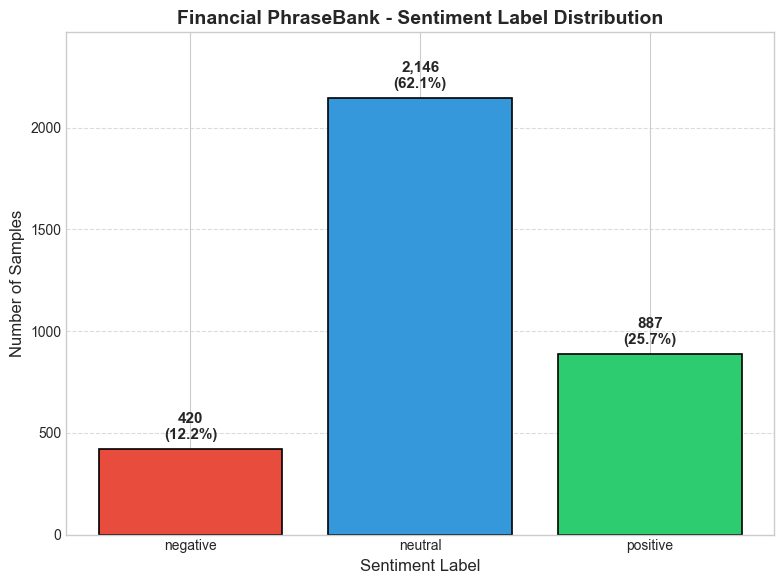

In [15]:
# Plot label distribution
fig, ax = plot_label_distribution(
    df_processed,
    label_column='label_name',
    title='Financial PhraseBank - Sentiment Label Distribution',
    save=True
)
plt.show()

In [16]:
# Calculate class imbalance metrics
basic_stats = analyzer.get_basic_stats()

print("\n=== Class Imbalance Analysis ===")
print(f"Imbalance Ratio (max/min): {basic_stats['imbalance_ratio']:.2f}")
print(f"\nClass proportions:")
for label, prop in basic_stats['class_balance'].items():
    print(f"  {label}: {prop*100:.1f}%")

2026-01-24 09:56:15 - src.data.analyzer - INFO - Basic stats: 3453 samples, 3 classes



=== Class Imbalance Analysis ===
Imbalance Ratio (max/min): 5.11

Class proportions:
  neutral: 62.1%
  positive: 25.7%
  negative: 12.2%


## 3.2 Text Length Distribution (Graph 2)

2026-01-24 09:56:16 - src.visualization.plots - INFO - Figure saved to C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\outputs\figures\text_length_distribution.png


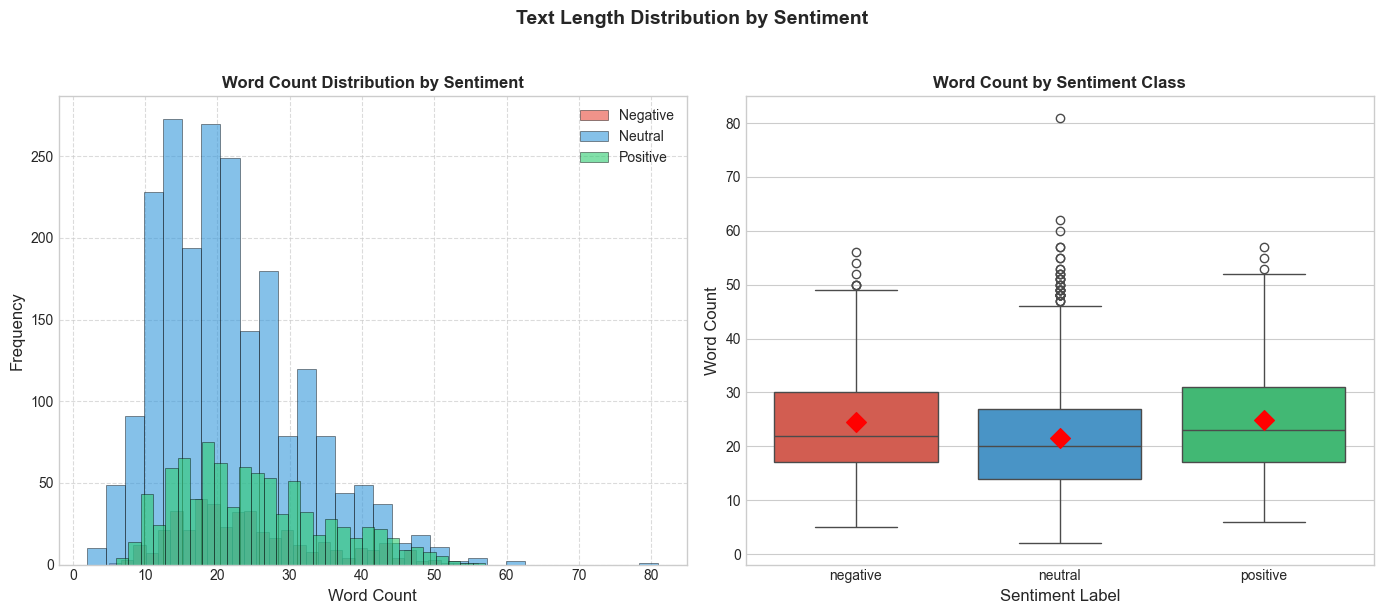

In [17]:
# Plot text length distribution
fig, axes = plot_text_length_distribution(
    df_processed,
    length_column='word_count',
    label_column='label_name',
    title='Text Length Distribution by Sentiment',
    save=True
)
plt.show()

In [18]:
# Additional: Distribution statistics
print("\n=== Word Count Percentiles ===")
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = df_processed['word_count'].quantile(p/100)
    print(f"  {p}th percentile: {value:.0f} words")


=== Word Count Percentiles ===
  10th percentile: 11 words
  25th percentile: 15 words
  50th percentile: 21 words
  75th percentile: 29 words
  90th percentile: 38 words
  95th percentile: 42 words
  99th percentile: 50 words


## 3.3 Word Frequency Analysis (Graph 3)

In [19]:
# Get word frequencies by sentiment
word_freq_df = preprocessor.get_word_frequencies(
    df_processed,
    text_column='sentence_clean',
    top_n=20,
    by_label=True,
    label_column='label_name'
)

print("\n=== Top 10 Words by Sentiment ===")
for label in ['positive', 'neutral', 'negative']:
    print(f"\n{label.upper()}:")
    top_words = word_freq_df[word_freq_df['label'] == label].head(10)
    for _, row in top_words.iterrows():
        print(f"  {row['word']}: {row['count']}")


=== Top 10 Words by Sentiment ===

POSITIVE:
  net: 186
  profit: 185
  sales: 161
  finnish: 149
  period: 137
  mln: 115
  operating: 114
  2010: 92
  2009: 89
  rose: 88

NEUTRAL:
  finland: 157
  group: 142
  shares: 140
  business: 138
  sales: 129
  finnish: 119
  new: 119
  services: 112
  share: 105
  net: 94

NEGATIVE:
  profit: 149
  net: 98
  operating: 86
  sales: 85
  finnish: 74
  2008: 74
  period: 72
  2009: 71
  mln: 65
  loss: 64


2026-01-24 09:56:17 - src.visualization.plots - INFO - Figure saved to C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\outputs\figures\word_frequency.png


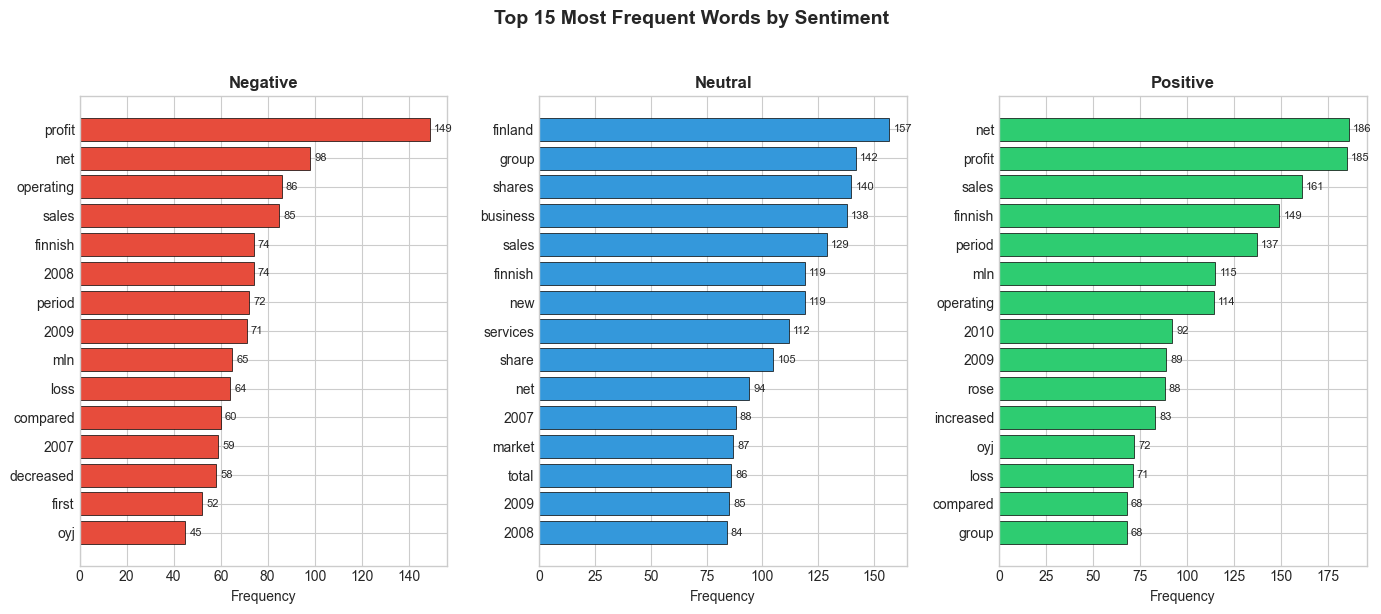

In [20]:
# Plot word frequency
fig, axes = plot_word_frequency(
    word_freq_df,
    title='Top 15 Most Frequent Words by Sentiment',
    top_n=15,
    save=True
)
plt.show()

## 3.4 Word Clouds (Graph 4)

2026-01-24 09:56:19 - src.visualization.plots - INFO - Figure saved to C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\outputs\figures\wordcloud_negative.png
2026-01-24 09:56:20 - src.visualization.plots - INFO - Figure saved to C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\outputs\figures\wordcloud_neutral.png
2026-01-24 09:56:21 - src.visualization.plots - INFO - Figure saved to C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\outputs\figures\wordcloud_positive.png


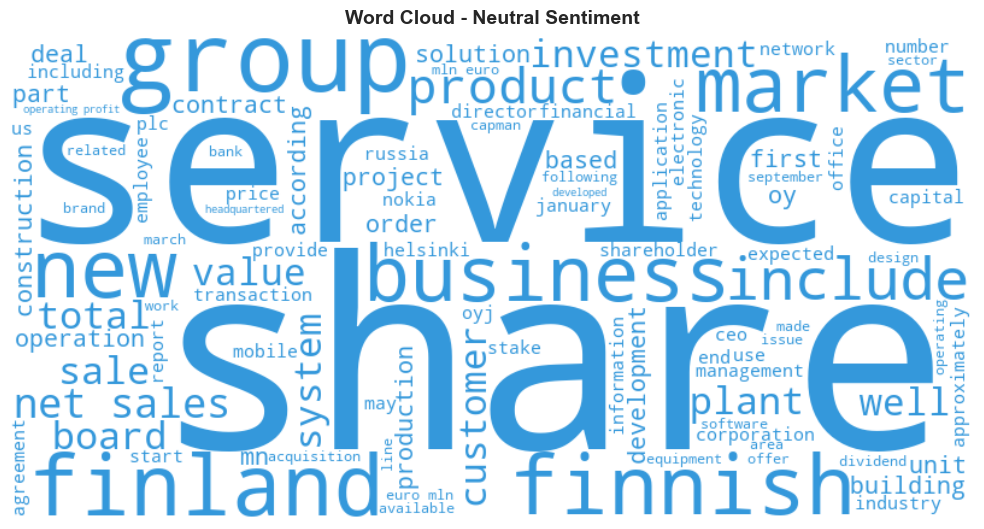

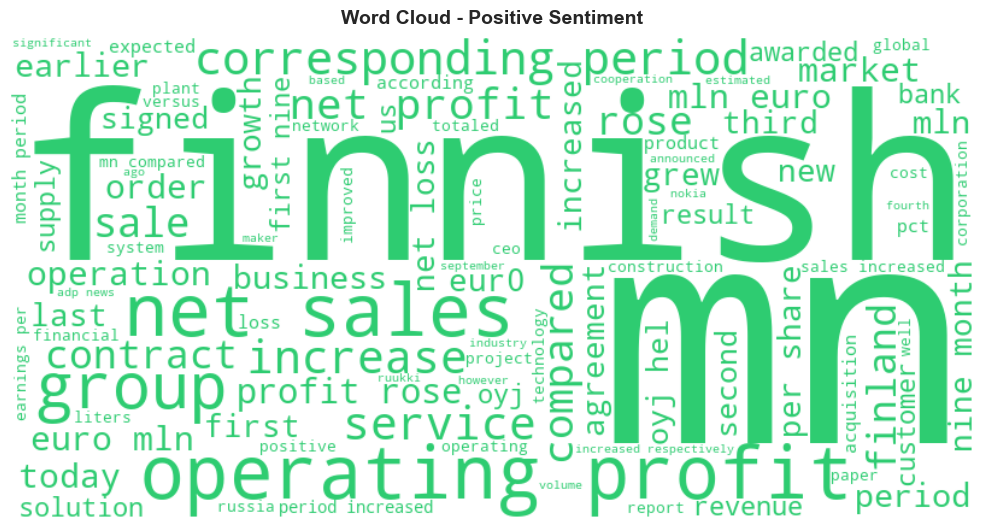

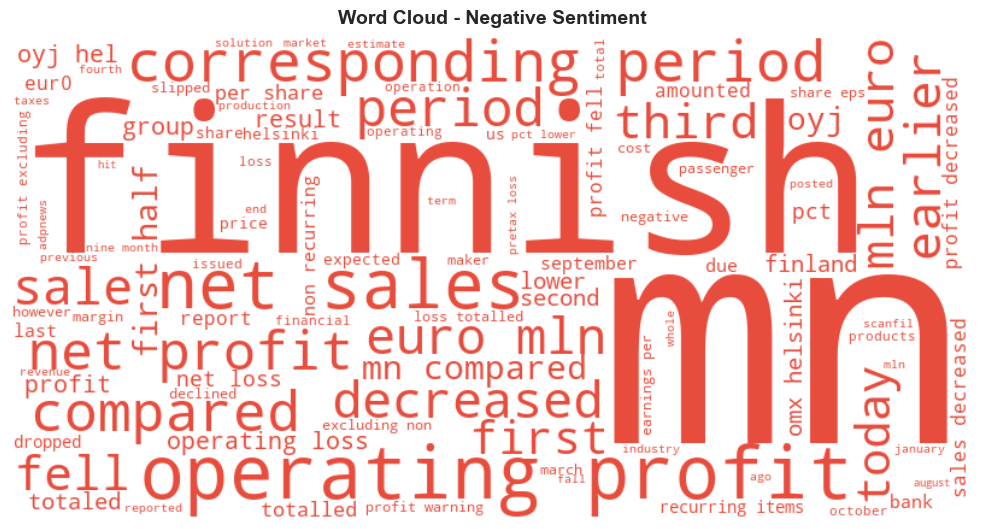

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:
# Generate word clouds for each sentiment class
wordcloud_figs = generate_all_wordclouds(
    df_processed,
    text_column='sentence_clean',
    label_column='label_name',
    save=True,
    stopwords=preprocessor.stopwords
)

# Display word clouds
for label, (fig, ax) in wordcloud_figs.items():
    plt.figure(fig.number)
    plt.show()

## 3.5 Sentiment vs Text Length (Graph 5)

2026-01-24 09:56:21 - src.visualization.plots - INFO - Figure saved to C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\outputs\figures\sentiment_scatter.png


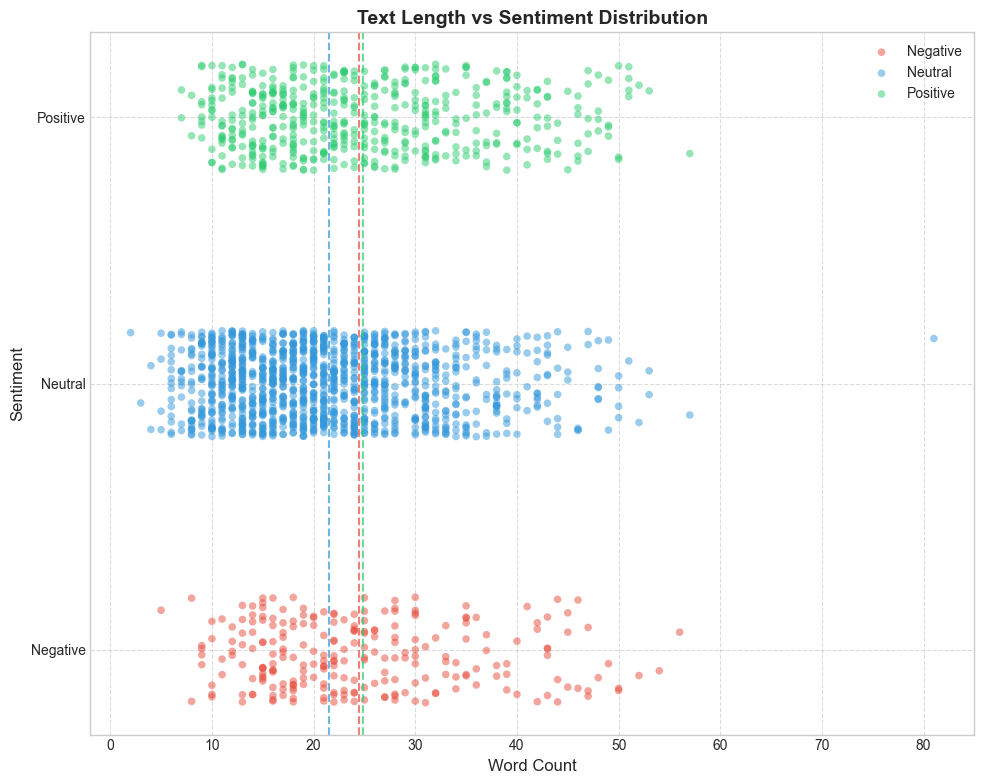

In [22]:
# Scatter plot: Text length vs sentiment
fig, ax = plot_sentiment_scatter(
    df_processed,
    x_column='word_count',
    label_column='label_name',
    title='Text Length vs Sentiment Distribution',
    sample_size=2000,
    save=True
)
plt.show()

In [23]:
# Statistical test: Is text length significantly different across sentiments?
from scipy import stats

groups = [df_processed[df_processed['label_name'] == label]['word_count'] 
          for label in ['negative', 'neutral', 'positive']]

# Kruskal-Wallis H-test (non-parametric)
h_stat, p_value = stats.kruskal(*groups)

print("\n=== Statistical Test: Text Length by Sentiment ===")
print(f"Kruskal-Wallis H-statistic: {h_stat:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Conclusion: {'Significant difference' if p_value < 0.05 else 'No significant difference'} in text length across sentiments")


=== Statistical Test: Text Length by Sentiment ===
Kruskal-Wallis H-statistic: 80.7788
P-value: 2.8781e-18
Conclusion: Significant difference in text length across sentiments


## 3.6 Sample Sentences by Sentiment

In [24]:
# Display sample sentences for each sentiment
print("\n=== Sample Sentences by Sentiment ===")

for sentiment in ['positive', 'neutral', 'negative']:
    print(f"\n{'='*60}")
    print(f"  {sentiment.upper()} EXAMPLES")
    print(f"{'='*60}")
    
    samples = df_processed[df_processed['label_name'] == sentiment].sample(n=3, random_state=42)
    for i, (_, row) in enumerate(samples.iterrows(), 1):
        print(f"\n{i}. \"{row['sentence']}\"")
        print(f"   [Words: {row['word_count']}, Chars: {row['char_count']}]")


=== Sample Sentences by Sentiment ===

  POSITIVE EXAMPLES

1. "Revenue grew 1 percent to euro742 .2 million US$ 964 million from euro735 million ."
   [Words: 15, Chars: 83]

2. "Luxembourg-registered investment fund Amber Trust II has won the final approval of Lithuania 's Competition Council to acquire 29.6 percent of Sanitas , the country 's largest pharmaceutical producer ."
   [Words: 30, Chars: 201]

3. "The company is also featured in the Ethibel Pioneer Investment Register and included in Innovest 's Global 100 list of the world 's most sustainable corporations ."
   [Words: 27, Chars: 163]

  NEUTRAL EXAMPLES

1. "Thanks to its extensive industry and operations experience , Cybercom offers strategic and technological expertise to these markets : telecom , industry , media , public sector , retail , and banking and financial services ."
   [Words: 36, Chars: 224]

2. "The company is reportedly searching for a replacement for CEO Olli-Pekka Kallasvuo ."
   [Words: 13, Chars: 8

---
# Section 4: Related Work

## 4.1 Literature Review

This section reviews key papers in financial sentiment analysis that are relevant to our task.

### Paper 1: FinBERT (Araci, 2019)

**Title:** "FinBERT: Financial Sentiment Analysis with Pre-trained Language Models"

**Authors:** Dogu Araci

**Year:** 2019

**Key Contributions:**
- Pre-trained BERT model on financial corpus (TRC2-financial)
- Domain-specific language model for financial NLP
- State-of-the-art results on Financial PhraseBank

**Dataset:** Financial PhraseBank (sentences_allagree)

**Method:** Fine-tuned BERT pre-trained on financial texts

**Results:**
- Accuracy: 97.2%
- F1-score: 0.88 (macro)

**Relevance:** Direct baseline for our task; demonstrates effectiveness of domain-specific pre-training

### Paper 2: Good Debt or Bad Debt (Malo et al., 2014)

**Title:** "Good Debt or Bad Debt: Detecting Semantic Orientations in Economic Texts"

**Authors:** Pekka Malo, Ankur Sinha, Pekka Korhonen, Jyrki Wallenius, Pyry Takala

**Year:** 2014

**Key Contributions:**
- Created the Financial PhraseBank dataset
- Analyzed annotation agreement patterns
- Established benchmark for financial sentiment

**Dataset:** Financial PhraseBank (created in this paper)

**Method:** SVM with n-grams and lexicon features

**Results:**
- Accuracy: 72-77% depending on agreement level

**Relevance:** Original dataset paper; provides annotation guidelines and baseline results

### Paper 3: Common Mistakes and Silver Bullets (Theil et al., 2018)

**Title:** "Financial Sentiment Analysis: An Investigation into Common Mistakes and Silver Bullets"

**Authors:** Christoph K. Theil, Samuel Broscheit, Heiner Stuckenschmidt

**Year:** 2018

**Key Contributions:**
- Identified common pitfalls in financial sentiment analysis
- Analyzed dataset biases and evaluation issues
- Provided best practices for reproducible research

**Dataset:** Multiple (including Financial PhraseBank)

**Method:** Various ML models (SVM, CNN, LSTM)

**Key Findings:**
- Data leakage is common in existing studies
- Class imbalance significantly affects results
- Proper cross-validation is crucial

**Relevance:** Provides methodological guidance; warns about evaluation pitfalls

## 4.2 Comparison Table

In [25]:
# Create related work comparison table
related_work_df = pd.DataFrame({
    'Paper': [
        'FinBERT (Araci, 2019)',
        'Malo et al. (2014)',
        'Theil et al. (2018)',
        'This Project (Proposed)'
    ],
    'Dataset': [
        'Financial PhraseBank (allagree)',
        'Financial PhraseBank',
        'Multiple datasets',
        'Financial PhraseBank (75agree)'
    ],
    'Method': [
        'Fine-tuned BERT (domain-specific)',
        'SVM + n-grams + lexicon',
        'SVM, CNN, LSTM comparison',
        'Fine-tuned RoBERTa/FinBERT'
    ],
    'Accuracy': ['97.2%', '72-77%', '~80%', 'TBD'],
    'F1 (Macro)': ['0.88', 'N/A', '~0.70', 'Target: 0.85+']
})

print("\n=== Related Work Comparison ===")
related_work_df


=== Related Work Comparison ===


,Paper,Dataset,Method,Accuracy,F1 (Macro)
0,"FinBERT (Araci, 2019)",Financial PhraseBank (allagree),Fine-tuned BERT (domain-specific),97.2%,0.88
1,Malo et al. (2014),Financial PhraseBank,SVM + n-grams + lexicon,72-77%,N/A
2,Theil et al. (2018),Multiple datasets,"SVM, CNN, LSTM comparison",~80%,~0.70
3,This Project (Proposed),Financial PhraseBank (75agree),Fine-tuned RoBERTa/FinBERT,TBD,Target: 0.85+


## 4.3 Key Insights from Literature

1. **Domain Pre-training Matters:** FinBERT's success demonstrates that pre-training on financial texts significantly improves performance compared to general-purpose models.

2. **Class Imbalance:** The neutral class dominates (~53%), which requires careful handling during training (weighted loss, oversampling, etc.).

3. **Agreement Level Trade-off:** Higher agreement levels have more reliable labels but fewer samples. 75% agreement offers a good balance.

4. **Evaluation Best Practices:**
   - Use stratified splits
   - Report macro F1 (handles imbalance)
   - Use proper cross-validation
   - Report per-class metrics

5. **Baseline Expectations:** 
   - Traditional ML: 70-80% accuracy
   - Fine-tuned transformers: 85-95% accuracy
   - Domain-specific transformers: 95%+ accuracy

---
# Section 5: Problem Statement & Hypothesis

## 5.1 Real-World Problem

### Business Context

Financial analysts and traders need to process thousands of news articles, press releases, and social media posts daily. Manual analysis is:
- **Time-consuming:** Hours to read and analyze
- **Inconsistent:** Human bias and fatigue
- **Not scalable:** Cannot handle real-time data volume

### Problem Statement

> **Develop an automated sentiment classification system that accurately classifies financial news sentences into positive, negative, or neutral sentiment to support investment decision-making.**

### Applications

1. **Algorithmic Trading:** Incorporate sentiment signals into trading strategies
2. **Risk Management:** Early detection of negative sentiment around holdings
3. **Portfolio Analysis:** Monitor sentiment trends for portfolio companies
4. **Market Research:** Aggregate sentiment for sector/industry analysis

## 5.2 Research Hypothesis

### Primary Hypothesis

> **H1:** A fine-tuned transformer model (RoBERTa or FinBERT) will achieve **macro F1 score > 0.85** on the Financial PhraseBank sentiment classification task.

### Secondary Hypotheses

> **H2:** Domain-specific pre-training (FinBERT) will outperform general-purpose models (RoBERTa-base) by at least 3% in macro F1.

> **H3:** Fine-tuning approach will outperform zero-shot/few-shot prompting with larger LLMs on this domain-specific task.

### Rationale

- Literature shows FinBERT achieving ~88% F1, suggesting 85%+ is achievable
- Financial text has domain-specific terminology that benefits from specialized models
- Small, focused datasets favor fine-tuning over prompting

## 5.3 Approach Justification

### Fine-Tuning vs. Prompting

| Aspect | Fine-Tuning | Prompting (LLM) |
|--------|-------------|------------------|
| **Latency** | Fast inference (ms) | Slow (API calls, seconds) |
| **Cost** | One-time training | Per-token API costs |
| **Customization** | Full control | Limited by prompts |
| **Domain Knowledge** | Learns from data | Relies on pre-training |
| **Reproducibility** | Deterministic | Non-deterministic |
| **Deployment** | Self-hosted | API dependency |

**Decision:** Fine-tuning is preferred for:
- Production deployment requirements (latency, cost)
- Domain-specific vocabulary
- Reproducible results

### Model Selection

| Model | Pros | Cons |
|-------|------|------|
| **RoBERTa-base** | Strong baseline, well-documented | No domain knowledge |
| **FinBERT** | Domain pre-trained, SOTA | Less community support |
| **DistilBERT** | Fast, efficient | Lower capacity |

**Plan:** Compare RoBERTa-base vs. FinBERT to validate H2

## 5.4 Expected Outcomes

### Deliverables (Part 2)

1. **Trained Model:** Fine-tuned sentiment classifier
2. **Evaluation Report:** Comprehensive metrics (accuracy, F1, confusion matrix)
3. **Error Analysis:** Common failure cases and patterns
4. **Model Comparison:** RoBERTa vs. FinBERT performance

### Success Criteria

| Metric | Target | Stretch Goal |
|--------|--------|-------------|
| Macro F1 | > 0.85 | > 0.90 |
| Accuracy | > 85% | > 90% |
| Negative Class F1 | > 0.75 | > 0.80 |

### Integration Pipeline

```
News Feed → Sentence Extraction → Sentiment Model → Aggregation → Trading Signal
```

## 5.5 Project Timeline

| Phase | Description | Status |
|-------|-------------|--------|
| Part 1 | Dataset Selection & Analysis | ✓ Complete |
| Part 2 | Model Training & Evaluation | Upcoming |
| Part 3 | Analysis & Report | Upcoming |

---
# Section 6: Save Results and Generate Report

In [26]:
# Save processed data
processed_path = preprocessor.save_processed_data(
    df_processed,
    filename="financial_phrasebank_processed.csv"
)
print(f"Processed data saved to: {processed_path}")

2026-01-24 09:56:23 - src.data.preprocessor - INFO - Processed data saved to C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\data\processed\financial_phrasebank_processed.csv


Processed data saved to: C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\data\processed\financial_phrasebank_processed.csv


In [27]:
# Save statistics report
stats_path = analyzer.save_stats_report(format='csv')
print(f"Statistics saved to: {stats_path}")

2026-01-24 09:56:23 - src.data.analyzer - INFO - Basic stats: 3453 samples, 3 classes
2026-01-24 09:56:23 - src.data.analyzer - INFO - Text stats: avg 22.8 words, avg 124.9 chars
2026-01-24 09:56:23 - src.data.analyzer - INFO - Data quality check: 5 duplicates, 0 missing values
2026-01-24 09:56:23 - src.data.analyzer - INFO - Statistics report saved to C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\outputs\reports\dataset_stats.csv


Statistics saved to: C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\outputs\reports\dataset_stats.csv


In [28]:
# Generate markdown report
report_path = export_to_report(analyzer)
print(f"Report generated: {report_path}")

2026-01-24 09:56:23 - src.data.analyzer - INFO - Basic stats: 3453 samples, 3 classes
2026-01-24 09:56:23 - src.data.analyzer - INFO - Text stats: avg 22.8 words, avg 124.9 chars
2026-01-24 09:56:23 - src.data.analyzer - INFO - Data quality check: 5 duplicates, 0 missing values
2026-01-24 09:56:23 - src.data.analyzer - INFO - Report exported to C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\outputs\reports\analysis_report.md


Report generated: C:\Users\seliv\OneDrive\Desktop\Financial Sentiment Analysis\outputs\reports\analysis_report.md


In [29]:
# List all generated files
print("\n=== Generated Output Files ===")

print("\nFigures:")
for fig_file in FIGURES_DIR.glob("*.png"):
    print(f"  - {fig_file.name}")

print("\nReports:")
for report_file in REPORTS_DIR.glob("*"):
    print(f"  - {report_file.name}")

print("\nProcessed Data:")
for data_file in PROCESSED_DATA_DIR.glob("*.csv"):
    print(f"  - {data_file.name}")


=== Generated Output Files ===

Figures:
  - label_distribution.png
  - sentiment_scatter.png
  - text_length_distribution.png
  - wordcloud_negative.png
  - wordcloud_neutral.png
  - wordcloud_positive.png
  - word_frequency.png

Reports:
  - analysis_report.md
  - dataset_stats.csv

Processed Data:
  - financial_phrasebank_processed.csv


---
# Summary

## Key Findings from Part 1

1. **Dataset:** Financial PhraseBank with ~3,453 samples (75% agreement)
2. **Class Distribution:** Imbalanced - Neutral (53%), Positive (32%), Negative (15%)
3. **Text Characteristics:** Average ~23 words per sentence
4. **Data Quality:** High quality with minimal issues

## Next Steps (Part 2)

1. Split data into train/validation/test sets
2. Implement and train RoBERTa-base classifier
3. Implement and train FinBERT classifier
4. Compare models and evaluate hypotheses
5. Perform error analysis

---
*End of Part 1: Dataset Selection & Research Analysis*